In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Task 1: Image Segmentation Using Thresholding

In [69]:
image1 = cv2.imread("/kaggle/input/a4-dataset-dip/images/image1.webp", cv2.IMREAD_GRAYSCALE)

In [70]:
_, binary_thresh = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(image1, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

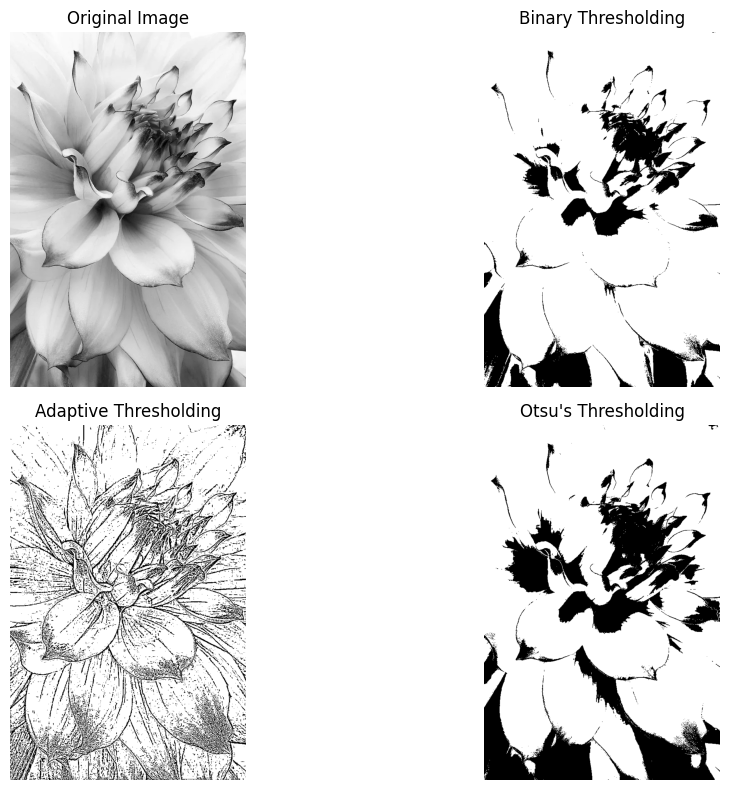

In [71]:
titles = ['Original Image', 'Binary Thresholding', 'Adaptive Thresholding', "Otsu's Thresholding"]
images = [image1, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(12, 8))

for idx, (img, title) in enumerate(zip(images, titles), start=1):
    plt.subplot(2, 2, idx)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')  

plt.tight_layout()
plt.show()


Adaptive thresholding is the most effective among the three methods, providing the clearest edges and the most precise results. Otsu's method comes in second, but it lacks the level of detail achieved by adaptive thresholding. Simple thresholding is the least effective, delivering the least distinct edges and the least accurate outcomes.

### Task 2: Line Detection Using Hough Transform

In [82]:
image2 = cv2.imread("/kaggle/input/a4-dataset/images/img2.jpeg", cv2.IMREAD_COLOR)

_, image2 = cv2.threshold(image2, 127, 255, cv2.THRESH_BINARY)

In [83]:
image2.shape

(640, 640, 3)

In [84]:
def detect_and_draw_lines(image, rho=1, theta=np.pi / 180, threshold=80):
    """
    Detects lines in an image using the Hough Transform and overlays them on the image.

    Args:
        image (ndarray): Input image.
        rho (int, optional): Distance resolution of the accumulator in pixels. Default is 1.
        theta (float, optional): Angle resolution of the accumulator in radians. Default is π/180.
        threshold (int, optional): Accumulator threshold parameter for Hough Line Transform. Default is 80.

    Returns:
        result_image (ndarray): Image with detected lines drawn.
        edges (ndarray): Edge-detected binary image.
    """
    # Convert to grayscale if the image has multiple channels
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Perform edge detection
    edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)

    # Detect lines using the Hough Transform
    lines = cv2.HoughLines(edges, rho, theta, threshold)

    # Create a copy of the original image to draw the lines
    output_image = image.copy()

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            cos_theta, sin_theta = np.cos(theta), np.sin(theta)
            x0, y0 = rho * cos_theta, rho * sin_theta
            # Calculate line endpoints for visualization
            x1, y1 = int(x0 + 1000 * (-sin_theta)), int(y0 + 1000 * cos_theta)
            x2, y2 = int(x0 - 1000 * (-sin_theta)), int(y0 - 1000 * cos_theta)
            # Draw the line on the output image
            cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 1)

    return output_image, edges


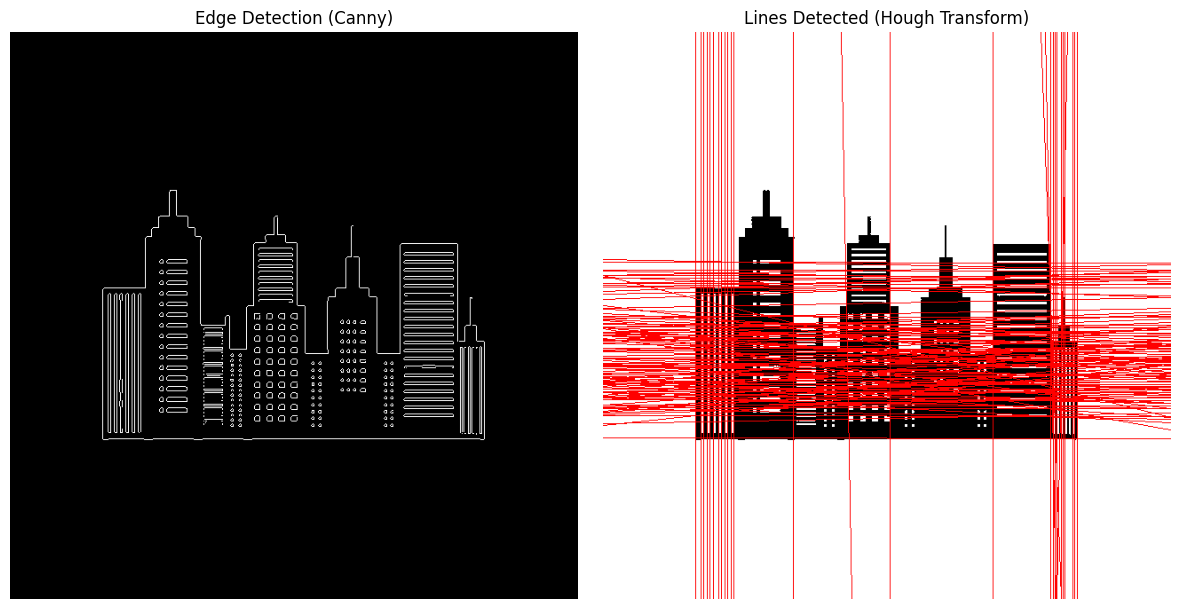

In [85]:
# Apply the line detection function
result_image, edges = detect_and_draw_lines(image2)

# Visualize the edge detection and line detection results
plt.figure(figsize=(12, 6))

# Display edge-detected image
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny)')
plt.axis('off')  # Hide axes for better visualization

# Display the original image with lines highlighted
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for accurate colors
plt.title('Lines Detected (Hough Transform)')
plt.axis('off')  # Hide axes

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

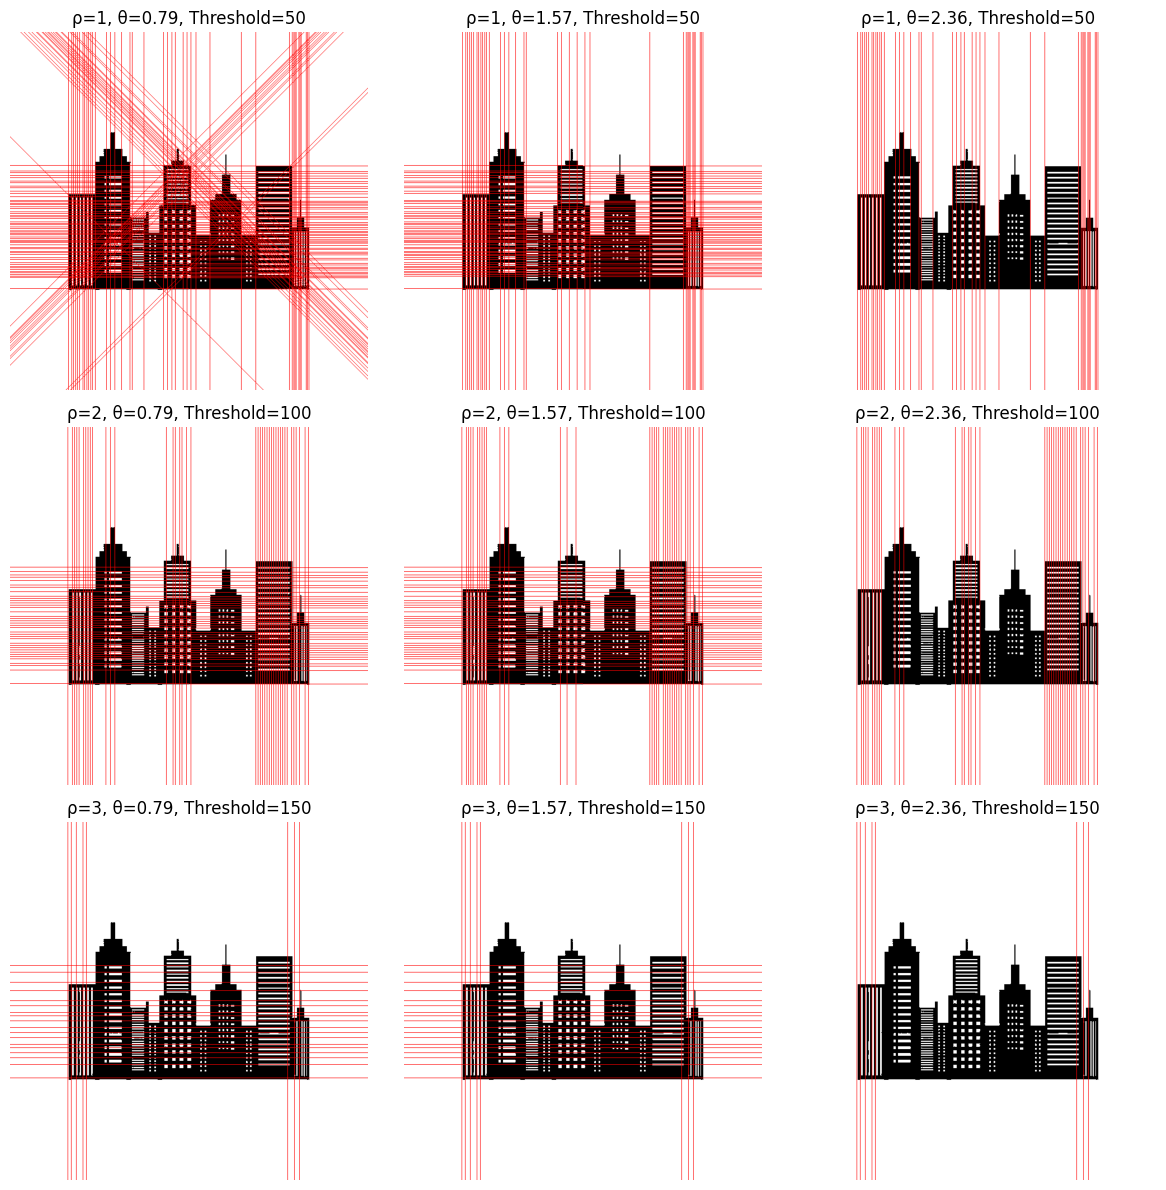

In [86]:
# Define parameter values for rho, theta, and threshold
rho_values = [1, 2, 3]
theta_values = np.radians([45, 90, 135])  # Convert degrees to radians
threshold_values = [50, 100, 150]

# Set up a 3x3 grid for displaying results
plt.figure(figsize=(12, 12))

# Loop through the combinations of parameters and display results
for row, rho in enumerate(rho_values):
    for col, theta in enumerate(theta_values):
        result_image, edges = detect_and_draw_lines(image2, rho=rho, theta=theta, threshold=threshold_values[row])
        
        # Plot each result in the corresponding grid cell
        plt.subplot(3, 3, 3 * row + col + 1)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
        plt.title(f"ρ={rho}, θ={theta:.2f}, Threshold={threshold_values[row]}")
        plt.axis('off')  # Remove axis for better visualization

# Adjust layout for proper spacing
plt.tight_layout()
plt.show()


The HoughLines function takes three key parameters: rho, theta, and threshold.

rho: Specifies the distance resolution of the accumulator in pixels.
theta: Defines the angle resolution of the accumulator in radians.
threshold: Sets the minimum number of intersections required to detect a line.
Higher threshold values reduce the number of detected lines, as only stronger line candidates are considered. Conversely, increasing the rho and theta resolutions can result in detecting more lines, as demonstrated in the output of the code.

### Task 3: Circle Detection Using Hough Circle Transform

In [87]:
image3 = cv2.imread("/kaggle/input/a4-dataset-dip/images/image2.webp", cv2.IMREAD_COLOR)

In [88]:
def detect_and_draw_circles(image, minDist=30, cannyThresh=50, accThresh=30):
    """
    Detects circles in an image using the Hough Circle Transform and draws them.

    Args:
        image (ndarray): Input image (grayscale or BGR).
        minDist (int, optional): Minimum distance between detected circle centers. Default is 30.
        cannyThresh (int, optional): Threshold for edge detection in the Canny detector. Default is 50.
        accThresh (int, optional): Accumulator threshold for the circle centers. Default is 30.

    Returns:
        result_image (ndarray): Image with detected circles drawn.
    """
    # Convert to grayscale if the input is a color image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)

    # Detect circles using the Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=minDist,
        param1=cannyThresh,
        param2=accThresh,
        minRadius=0,
        maxRadius=100
    )

    # Create a copy of the original image to draw detected circles
    output_image = image.copy()

    if circles is not None:
        # Convert circle coordinates and radius to integers
        circles = np.uint16(np.around(circles))
        for x, y, radius in circles[0, :]:
            # Draw the circle perimeter
            cv2.circle(output_image, (x, y), radius, (0, 255, 0), 2)
            # Draw the circle center
            cv2.circle(output_image, (x, y), 2, (255, 0, 0), 3)

    return output_image


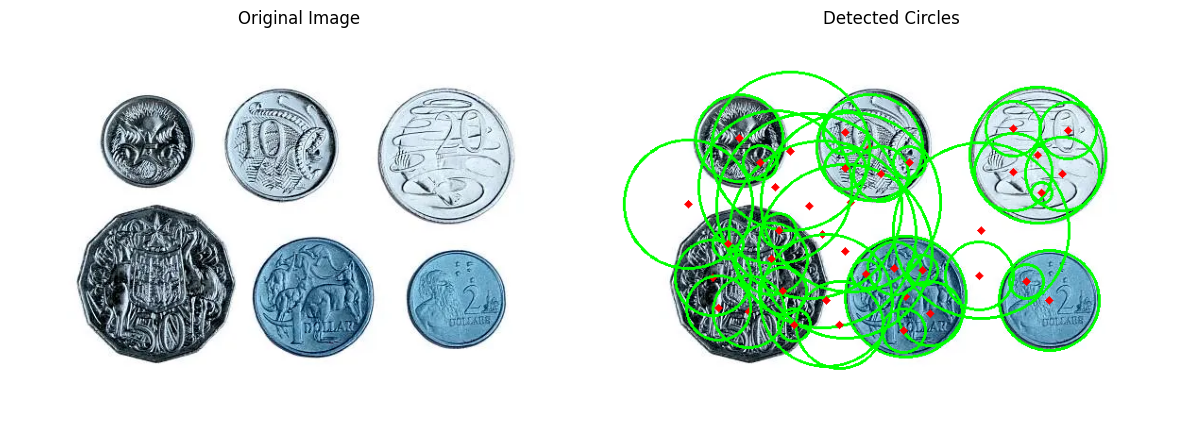

In [89]:
result_image = detect_circles(image3)

    # Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image3, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Detected Circles')
plt.axis('off')

plt.tight_layout()
plt.show()

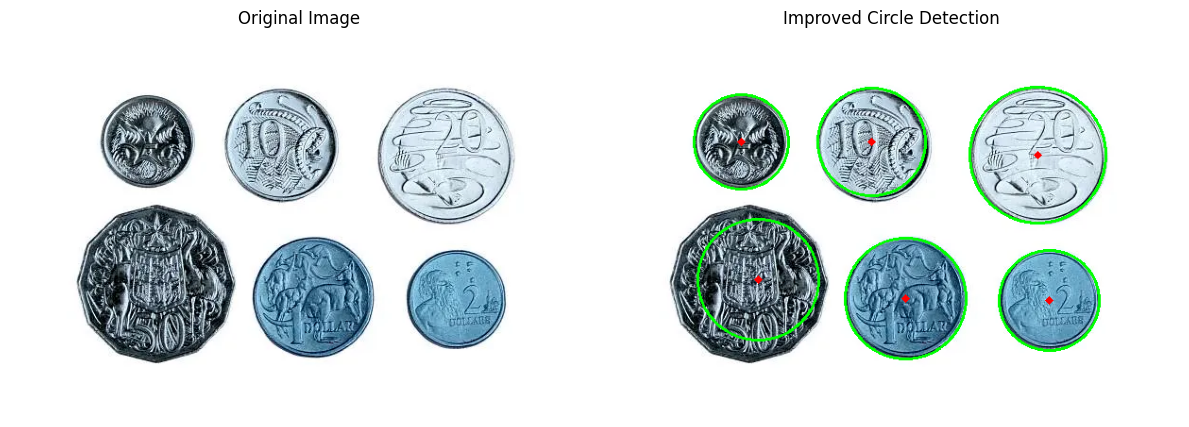

In [90]:
result_image = detect_circles(image3, minDist=40, cannyThresh=200, accThresh=45)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image3, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Improved Circle Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

The circles are effectively detected with the updated parameters, thanks to the higher Canny threshold and the lower accumulator threshold. A higher Canny threshold enhances edge detection for the circles, while a lower accumulator threshold improves circle detection accuracy by minimizing false positives.

### Task 4: Harris Corner Detection

In [91]:
img4 = cv2.imread("/kaggle/input/a4-dataset-dip/images/image4.webp", cv2.IMREAD_COLOR)

In [92]:
def detect_harris_corners(image, k=0.04, block_size=2, aperture_size=3, threshold=0.01):
    """
    Detects corners in an image using the Harris Corner Detection algorithm.

    Args:
        image (ndarray): Input image (grayscale or BGR).
        k (float, optional): Harris detector free parameter. Default is 0.04.
        block_size (int, optional): Neighborhood size for corner detection. Default is 2.
        aperture_size (int, optional): Aperture size for the Sobel operator. Default is 3.
        threshold (float, optional): Threshold for marking strong corners. Default is 0.01.

    Returns:
        img_with_corners (ndarray): Image with detected corners marked in red.
    """
    # Convert to grayscale if the input is a color image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Convert to float32 for processing
    gray_float = np.float32(gray_image)

    # Perform Harris corner detection
    corner_response = cv2.cornerHarris(gray_float, blockSize=block_size, ksize=aperture_size, k=k)

    # Enhance the corner regions for visibility
    dilated_response = cv2.dilate(corner_response, None)

    # Create a copy of the original image to mark the corners
    output_image = image.copy()
    # Mark detected corners in red
    output_image[dilated_response > threshold * dilated_response.max()] = [0, 0, 255]

    return output_image


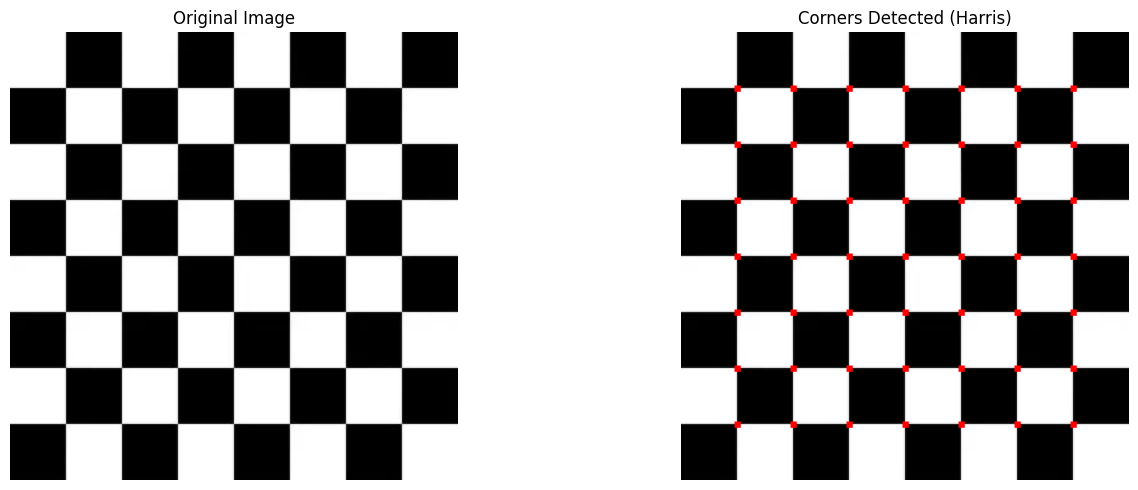

In [93]:
# Apply Harris Corner Detection to the image
img_with_corners = detect_harris_corners(img4)

# Create a figure to display the images side by side
plt.figure(figsize=(15, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.axis("off")

# Display the image with corners detected
plt.subplot(1, 2, 2)
plt.title("Corners Detected (Harris)")
plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.axis("off")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


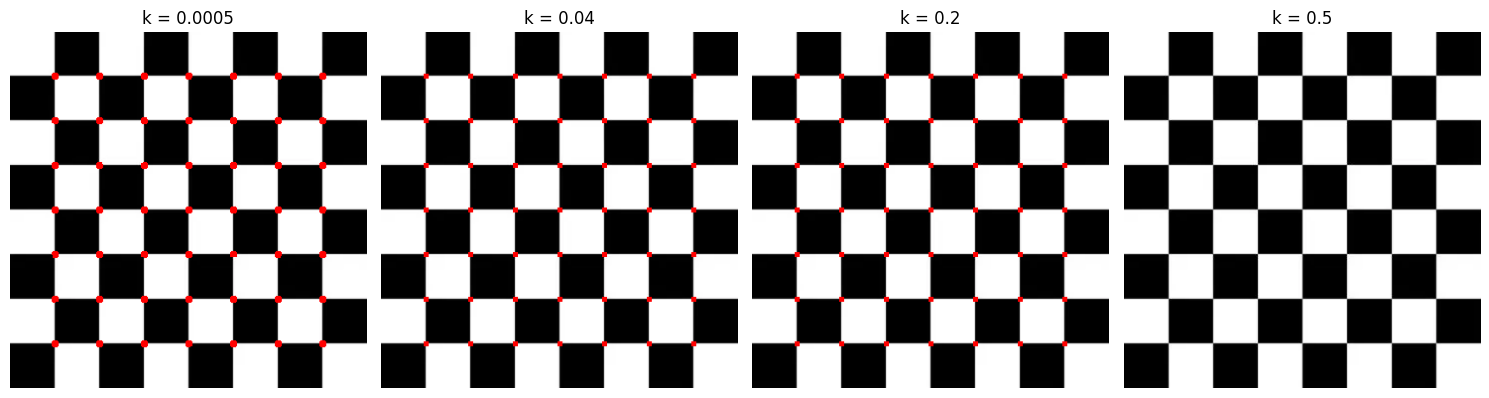

In [94]:
k_values = [0.0005, 0.04, 0.2, 0.5]  # Different values for the sensitivity parameter k

# Create a figure to display results in a 1x4 grid
plt.figure(figsize=(15, 5))
idx = 1

# Loop through all k values and apply Harris Corner Detection
for k in k_values:
    img_with_corners = detect_harris_corners(img4, k=k, block_size=2, aperture_size=3, threshold=0.01)
    
    # Display the results
    plt.subplot(1, 4, idx)
    plt.title(f"k = {k}")
    plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis("off")
    idx += 1

# Adjust the layout to prevent overlap and improve readability
plt.tight_layout()

# Show the final result
plt.show()



The k parameter in Harris Corner Detection influences the trade-off between detecting corners and edges. Lower values of k give more weight to corner strength, leading to a higher number of detected corners, though this may include some false positives. On the other hand, higher values of k emphasize edge strength, which results in fewer but more reliable corner detections. The ideal k value varies based on the image properties and the desired density of detected corners.

### Task 5: Short Theory

The Hough Transform (HT) is a technique used in image processing to detect geometric shapes, with varying levels of complexity depending on whether lines or circles are being detected.

For lines, the HT transforms points from the image into a 2D parameter space defined by rho (the perpendicular distance from the origin) and theta (the angle of the normal). Each image point corresponds to a sinusoidal curve in this space, and intersections of these curves reveal potential lines. This method is computationally efficient because it operates in a 2D parameter space.

For circles, the HT requires a 3D parameter space, as a circle is defined by three parameters: x_c (the x-coordinate of the center), y_c (the y-coordinate of the center), and r (the radius). This increases computational complexity, as each point in the image contributes to a 3D "voting" process over possible circle centers and radii.

Therefore, detecting circles is more computationally expensive than detecting lines due to the additional parameter and higher dimensionality involved.